## Michael DiGregorio

Find coefficients for a linear regression model
y = w_0 + w_1 * x

Need to: 
- Plot the data (x = first col, y = second col)
- Use python to find the coefficients using:
- The normal equation
- Batch and stochastic gradient descent
- determine an appropriate termination condition ( when the cost function is less than a threshold / after a given number of iterations)
- print the cost function vs iterations for each mode; compare and discuss batch and stochastic models in terms of the accuracy and speed of convergence
- choose the best learning rate, for example, plot cost function vs learning rate to determine the best learning rate

In [1]:
import numpy as np
import matplotlib.pyplot as pt

In [2]:
x, y = np.loadtxt("data2.txt", delimiter=',', unpack=True)
x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)
print(f"The shape of x is: {x.shape}")
print(f"The shape of y is: {y.shape}")
print("The first few values in x:")
print(x[:5])
print("The first few values in y:")
print(y[:5])

The shape of x is: (97, 1)
The shape of y is: (97, 1)
The first few values in x:
[[6.1101]
 [5.5277]
 [8.5186]
 [7.0032]
 [5.8598]]
The first few values in y:
[[17.592 ]
 [ 9.1302]
 [13.662 ]
 [11.854 ]
 [ 6.8233]]


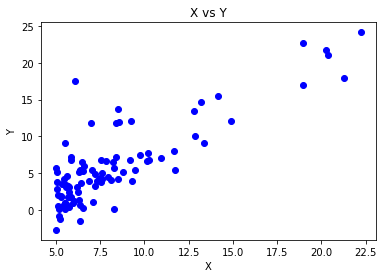

In [3]:
pt.plot(x, y, 'ob')
pt.title("X vs Y")
pt.xlabel("X")
pt.ylabel("Y")
pt.show()

## Closed Form Solution

The closed form solution for an unpenalized linear regression with least squares loss function:

$$(X_iW - Y_i)^2$$

where each $$X_i \epsilon R^{1x2} = [x_i;1]$$
and each $$W \epsilon R^{2x1} = [w;b]^T$$

and objective function:

$$min_W\sum_i(X_iW - Y_i)^2$$

is: 

$$W = (X^TX)^{-1}X^TY$$

Where X is an n-by-2 vector, Y is an n-by-1 vector, and W is a 2-by-1 vector

In [4]:
x_train = np.hstack((x, np.ones(x.shape)))
print(f"x_train shape: {x_train.shape}")

x_train shape: (97, 2)


In [5]:
xtx = np.dot(x_train.T, x_train)
xtx_inv = np.linalg.inv(xtx)
xty = np.dot(x_train.T, y)
W = np.dot(xtx_inv, xty)
print(f"W*: \n{W}")

W*: 
[[ 1.19303364]
 [-3.89578088]]


<ipython-input-6-47990874d5d1>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(x, y, 'ob', LineWidth=2)
<ipython-input-6-47990874d5d1>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
<ipython-input-6-47990874d5d1>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel("X", FontSize=16)
<ipython-input-6-47990874d5d1>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel("Y", FontSize=16)
<ipython-input-6-47990874d5d1>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


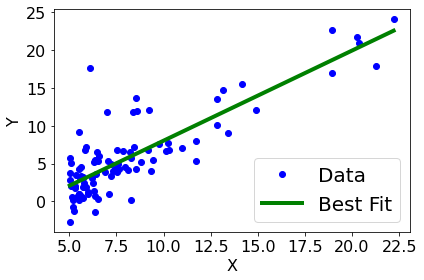

In [6]:
w1 = W[0]
w0 = W[1]

def get_regression_line(w0, w1, lower, upper):
    x = np.linspace(lower, upper, 100)
    return x, w1*x + w0

x_reg, y_reg = get_regression_line(w0, w1, min(x), max(x))

fig  = pt.figure(figsize=(6, 4))

line0, = pt.plot(x, y, 'ob', LineWidth=2)
line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
pt.xlabel("X", FontSize=16)
pt.ylabel("Y", FontSize=16)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0, line1], ["Data", "Best Fit"], fontsize=20)
pt.tight_layout()
pt.show()

## Gradient Descent

I have decided to add L2 regaularization to make convergence more stable

The objectve function with l2 regularization is defined as:
$$Q(W) = min_W(XW-Y)^2$$

With variables:
$$W \epsilon R^{2} = [w;b]^T$$
$$X \epsilon R^{nx2} = [x;1]^T$$
$$Y \epsilon R^{nx1} = [y]^T$$

The gradient of the objectve function w.r.t W is:
$$\frac{\partial Q(W)}{\partial W} = X^TXW - Y^TX $$

In [7]:
def mb_stochastic_objective_gradient(w, xi, yi, b):
    """
     Calculate the objective Q_I and the gradient of Q_I
     Inputs:
         w: d-by-1 matrix
         xi: b-by-d matrix
         yi: b-by-1 matrix
         lam: scalar, the regularization parameter
         b: integer, the batch size
     Return:
         obj: scalar, the objective Q_i
         g: d-by-1 matrix, gradient of Q_i
         
    I have decided to add l2 regularization to make the algorithm more stable
    """

    # calculate the objective
    obj = (1/b) * np.sum(np.power(np.dot(xi, w) - yi, 2), axis=0)
    
    # calculate the gradient
    xtx = np.dot(xi.T, xi)
    xtxw = np.dot(xtx, w)
    ytx = np.dot(xi.T, yi)
    g = xtxw - ytx
    
    return obj, g

In [8]:
def mb_sgd(x, y, b, stepsize, max_epoch=100, w=None, limit_output=0):
    """
     Mini-Batch SGD for solving logistic regression
     Inputs:
         x: n-by-d matrix
         y: n-by-1 matrix
         lam: scalar, the regularization parameter
         b: integer, the batch size
         stepsize: scalar
         max_epoch: integer, the maximal epochs
         w: d-by-1 matrix, initialization of w
     Return:
         w: the solution
         objvals: record of each iteration's objective value
    """
    n, d = x.shape
    objvals = np.zeros((max_epoch))
    
    if n % b != 0:
        print(x.shape)
        remainder = n%b
        print(remainder)
        x = x[:-remainder, ...]
        n, d = x.shape
        print(x.shape)
#         raise ValueError(f"Dataset must be evenly divisible into batches. Invalid batch length\nData length: {n}")
        
    if w is None:
        w = np.zeros((d, 1)) # zero initialization
        
    num_batches: int = n // b
    for e in range(max_epoch):
        rand_indices: np.ndarray = np.random.permutation(n)
        x_rand: np.ndarray = x[rand_indices, ...]
        y_rand: np.ndarray = y[rand_indices, ...]
        
        x_batch: np.ndarray = np.split(x_rand, num_batches)
        y_batch: np.ndarray = np.split(y_rand, num_batches)
        objval = 0 # accumulate objective values
        for i in range(num_batches): 
            obj, g = mb_stochastic_objective_gradient(w, x_batch[i], y_batch[i], b)
            objval += obj
            w -= stepsize*g

        objval /= num_batches
        objvals[e] = objval
        if limit_output <= 0:
            print(f'Objective value at epoch e={e} is {str(np.round(objval, 5))}')
    if limit_output <= 1:
        print(f'Objective value at epoch e={max_epoch} is {str(np.round(objvals[-1], 5))}')
         
        
    
    return w, objvals

In [9]:
#### MB-SGD with batch size b=1
#### Equivalent to stochastic gradient descent
b = 1
stepsize = 0.001 # you must tune this parameter
w, objvals_sgd = mb_sgd(x_train, y, b, stepsize, max_epoch=500, limit_output=2)
print(f"W* (Stochastic Gradient Descent): \n{w}")

W* (Stochastic Gradient Descent): 
[[ 1.1665422 ]
 [-3.94134633]]


<ipython-input-10-89a78808057d>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(x, y, 'ob', LineWidth=2)
<ipython-input-10-89a78808057d>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
<ipython-input-10-89a78808057d>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel("X", FontSize=16)
<ipython-input-10-89a78808057d>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel("Y", FontSize=16)
<ipython-input-10-89a78808057d>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases lat

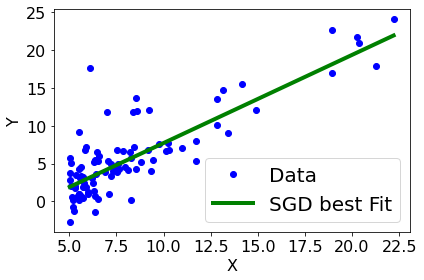

In [10]:
w1 = w[0]
w0 = w[1]

x_reg, y_reg = get_regression_line(w0, w1, min(x), max(x))

fig  = pt.figure(figsize=(6, 4))

line0, = pt.plot(x, y, 'ob', LineWidth=2)
line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
pt.xlabel("X", FontSize=16)
pt.ylabel("Y", FontSize=16)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0, line1], ["Data", "SGD best Fit"], fontsize=20)
pt.tight_layout()
pt.show()

## Iterations v Objective Function

<ipython-input-11-e0be8d3a6f54>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(epochs_sgd, objvals_sgd, '--b', LineWidth=4)
<ipython-input-11-e0be8d3a6f54>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Epochs', FontSize=20)
<ipython-input-11-e0be8d3a6f54>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-11-e0be8d3a6f54>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-11-e0be8d3a6f54>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor re

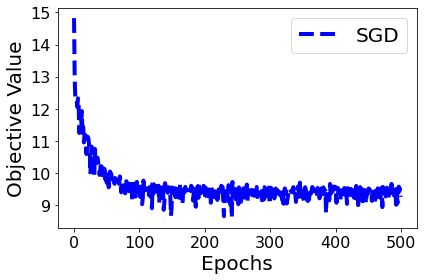

In [11]:
fig = pt.figure(figsize=(6, 4))
epochs_sgd = range(len(objvals_sgd))

line0, = pt.plot(epochs_sgd, objvals_sgd, '--b', LineWidth=4)
pt.xlabel('Epochs', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["SGD"], fontsize=20)
pt.tight_layout()
pt.show()

In [12]:
#### MB-SGD with batch size b=97
b = 97
stepsize = 0.000177 # you must tune this parameter
w, objvals_gd = mb_sgd(x_train, y, b, stepsize, max_epoch=500, limit_output=2)
print(f"W* (Gradient Descent): \n{w}")

W* (Gradient Descent): 
[[ 1.10825161]
 [-3.05184979]]


<ipython-input-13-70217adf945b>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(x, y, 'ob', LineWidth=2)
<ipython-input-13-70217adf945b>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
<ipython-input-13-70217adf945b>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel("X", FontSize=16)
<ipython-input-13-70217adf945b>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel("Y", FontSize=16)
<ipython-input-13-70217adf945b>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases lat

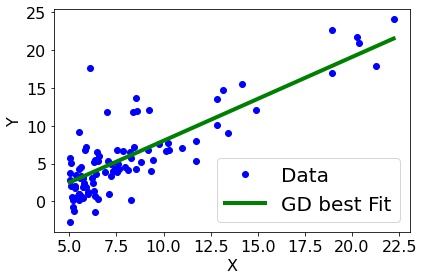

In [13]:
w1 = w[0]
w0 = w[1]

x_reg, y_reg = get_regression_line(w0, w1, min(x), max(x))

fig  = pt.figure(figsize=(6, 4))

line0, = pt.plot(x, y, 'ob', LineWidth=2)
line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
pt.xlabel("X", FontSize=16)
pt.ylabel("Y", FontSize=16)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0, line1], ["Data", "GD best Fit"], fontsize=20)
pt.tight_layout()
pt.show()

<ipython-input-14-910565adb285>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(epochs_gd[5:], objvals_gd[5:], '--b', LineWidth=4)
<ipython-input-14-910565adb285>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Epochs', FontSize=20)
<ipython-input-14-910565adb285>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-14-910565adb285>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-14-910565adb285>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two mi

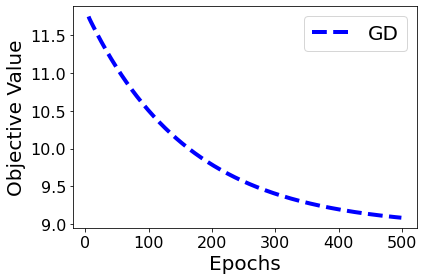

In [14]:
fig = pt.figure(figsize=(6, 4))
epochs_gd = range(len(objvals_gd))

line0, = pt.plot(epochs_gd[5:], objvals_gd[5:], '--b', LineWidth=4)
pt.xlabel('Epochs', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["GD"], fontsize=20)
pt.tight_layout()
pt.show()

## Learning Rate vs Objective Function

In [15]:
#### MB-SGD with batch size b=1
#### Equivalent to stochastic gradient descent
b = 1
# steps_sgd = np.linspace(0.0001, 0.5, 100)
steps_sgd = np.linspace(0.0001, 0.5, 100)
objvals_sgd = []
for step in steps_sgd:
    w, objval_sgd = mb_sgd(x_train, y, b, stepsize, max_epoch=150, limit_output=2)
    objvals_sgd.append(objval_sgd[-1])

<ipython-input-16-53edfe0b4ee3>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(steps_sgd, objvals_sgd, 'bo', LineWidth=4)
<ipython-input-16-53edfe0b4ee3>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Learning Rates', FontSize=20)
<ipython-input-16-53edfe0b4ee3>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-16-53edfe0b4ee3>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-16-53edfe0b4ee3>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two mi

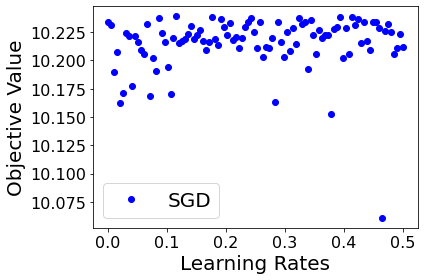

In [16]:
fig = pt.figure(figsize=(6, 4))

line0, = pt.plot(steps_sgd, objvals_sgd, 'bo', LineWidth=4)
pt.xlabel('Learning Rates', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["SGD"], fontsize=20)
pt.tight_layout()
pt.show()

In [17]:
#### MB-SGD with batch size b=97
b = 97
steps_gd = np.linspace(0.0001, 0.00025, 100)
objvals_gd = []
for step in steps_gd:
    w, objval_bsgd = mb_sgd(x_train, y, b, step, max_epoch=200, limit_output=2)
    objvals_gd.append(objval_bsgd[-1])

<ipython-input-18-cdf7691ec1ae>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(steps_gd, objvals_gd, 'bo', LineWidth=4)
<ipython-input-18-cdf7691ec1ae>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Learning Rates', FontSize=20)
<ipython-input-18-cdf7691ec1ae>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-18-cdf7691ec1ae>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-18-cdf7691ec1ae>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two mino

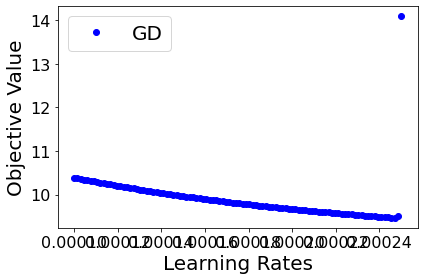

In [18]:
fig = pt.figure(figsize=(6, 4))

line0, = pt.plot(steps_gd, objvals_gd, 'bo', LineWidth=4)
pt.xlabel('Learning Rates', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["GD"], fontsize=20)
pt.tight_layout()
pt.show()

## Discussion

The batch gradient descent (referred to as gradient descent or GD from here on) converged in a smaller number of iterations than the stochastic gradient descent (SGD) algorithm, however, it took more epochs to do so. We tend to measure convergence through number of epochs becuase it represents the number of total passes through the dataset, so SGD converged faster than GD. The convergence of GD was significantly smoother than the convergence of SGD. In terms of accuracy, they were both able to converge to virtaully the same answer (+- 1% of the exact answer) within the given number of iterations, so I would assert that they are of similar accuracy. In terms of exploration of the solution space, SGD was able to cover more ground. For more complex solution spaces, SGD would converge to a better answer than GD. 